# Characterising the evolution of the user interests on YT

This notebook covers the whole pipeline of the project.

Here is the table content of the principal tasks : 
- **Data Processing**
- **Preparing Pyspark Model**
- **Topic modelling**
- **Results: Topic Coherence**
- **Classifier**


### 0.1 Imports

In [1]:
import collections
import fasttext
import gzip
import json
import math
import matplotlib
import nltk
import os
import pickle
import random
import scipy.sparse
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zstandard as zstd

from collections import Counter
from gensim.models.coherencemodel import CoherenceModel
from joblib import dump, load
from langdetect import detect
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from nltk.tokenize import RegexpTokenizer
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.types import LongType, StructField, StructType
from pyspark.ml.clustering import LDA, LDAModel, LocalLDAModel
from pyspark.ml.linalg import Vectors, SparseVector
from scipy.sparse import dok_matrix
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neural_network import MLPClassifier

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/olam/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1 Data Processing 

In this section, we will select the data for the topic modelling model as follow:

- videos has at least 10'000 views
- videos from channels with at least 100'000 subscribers

For that, we proceed as follow :

- first pass over the whole dataset in order to build the vocabulary and the keep the index of the relevant videos
- second pass over the whole dataset to construct a NxM sparse matrix, where N is the number of videos and M is the number of words in the vocabulary

In [2]:
# GET THE LIST OF RELEVANT CHANNELS

df_channelcrawler = pd.read_csv('/dlabdata1/youtube_large/channelcrawler.csv')

df_channelcrawler['channel_id'] = df_channelcrawler['link'].apply(
    lambda x: x.replace('http://www.youtube.com/channel/', ''))

# Filter channels with at least 100'000 subs
df_channelcrawler = df_channelcrawler[df_channelcrawler['subscribers'] >= 100000]

# Store in a set since it will be faster to check if a channel is in channelcrawler
set_relevant_channels = set(df_channelcrawler['channel_id'])

print('There are ' + str(len(set_relevant_channels)) + ' relevant channels.')

There are 50456 relevant channels.


In [2]:
# Setting NLP pre-processing features
stop_words = set(stopwords.words('english'))
tokenizer = RegexpTokenizer(r'\w+')
s_stemmer = SnowballStemmer(language='english')

In [3]:
def check_10000_views(video):
    try:
        view_counts = video['view_count']
        if view_counts != None:
            return view_counts >= 10000
        else:
            return False
    except KeyError:
        return False

In [4]:
def check_channel(video, set_relevant_channels):
    try:
        return video['channel_id'] in set_relevant_channels
    except:
        return False

In [5]:
def isEnglishAlpha(s):
    try:
        s.encode(encoding='utf-8').decode('ascii')
    except UnicodeDecodeError:
        return False
    else:
        return True

In [6]:
def get_freq_tokens_per_video(video):
    ''''''

    title_tokens = [w for w in tokenizer.tokenize(
        video['title'].lower()) if not w in stop_words]
    tag_tokens = [w for w in tokenizer.tokenize(
        video['tags'].lower()) if not w in stop_words]

    # We want to keep duplicates !!
    tokens_per_video = title_tokens + tag_tokens

    # Filter token with length < 3, with non english alphabet since fastext is not 100% accurate and remove numerical token
    tokens_keep = []
    for token in tokens_per_video:
        if len(token) >= 3 and (not token.isnumeric()) and isEnglishAlpha(token):
            tokens_keep.append(token)

    # Stemming
    stemmed_tokens_per_video = ([s_stemmer.stem(w) for w in tokens_keep])

    # Return a Counter object of the tokens
    return collections.Counter(stemmed_tokens_per_video)

### 1.1 First pass 
The first pass on the dataset will allow us to recover relevant videos and list of tokens

In [12]:
# Variable that contains the idx of every non english vid and that
# belongs to a channel in channelcrawler.csv TO BE USED IN SECOND ITER
set_relevant_vid = set()

# Variable first instanciated as set to check existing tokens efficiently,
# which will be a list in order to get the index for each tokens
set_stemmed_tokens = set()

i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            # line is a byte dict, video is the corresponding dict
            video = json.loads(line)

            if check_channel(video, set_relevant_channels) and check_10000_views(video):

                tokens_per_video = get_freq_tokens_per_video(video)

                set_relevant_vid.add(i)
                set_stemmed_tokens.update(tokens_per_video)

            if i % 10000000 == 0 and i != 0:
                print('Processed ' + str(i) + ' videos...')
                
            i += 1

Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [13]:
# save some intermediate results

with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_vid.pickle', 'wb') as f:
    pickle.dump(set_relevant_vid, f)
f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/set_stemmed_tokens.pickle', 'wb') as f:
    pickle.dump(set_stemmed_tokens, f)
f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_channels.pickle', 'wb') as f:
    pickle.dump(set_relevant_channels, f)
f.close()

### 1.2 Second pass 
The second pass on the dataset will allow us to create a NxM sparse matrix, where N is the number of videos and M is the number of words in the vocabulary

Notes:
- In order to keep the memory usage low, we will fill sparse matrix with only 1'000'000 rows and save them in the csr format
- Stack the saved sparse matrix together to get the final sparse matrix

In [7]:
def remove_zero_rows(M):
    '''Function that removes all rows from sparse matrix M that contains only zero.'''
    num_nonzeros = np.diff(M.indptr)
    return M[num_nonzeros != 0]

In [8]:
def fill_underlying_dict(freq_tokens_per_video, word2id, i_vid):
    '''Method to fill the underlying dictionnary in order to 
    update the sparse matrix incrementally by videos'''

    dict_freq_tokens_for_sparse_matrix = {}

    for key in freq_tokens_per_video.keys():

        # Column index in the sparse matrix (one column for each token)
        try:
            j_token = word2id[key]

            # Filling the underlying dict
            dict_freq_tokens_for_sparse_matrix[(
                i_vid % 1000000,   j_token)] = freq_tokens_per_video[key]

        except KeyError:
            None

    return dict_freq_tokens_for_sparse_matrix

In [16]:
# Get dimension of sparse matrix
size_of_tokens_dict = len(set_stemmed_tokens)
number_of_vid = len(set_relevant_vid)

# Create dictionnary of tokens with their indice
word2id = {}

# Fill dictionnary of tokens
for i, token in enumerate(set_stemmed_tokens):
    word2id[token] = i
    
id2word = {v: k for k, v in word2id.items()}

# Create mini sparse matrix
S = dok_matrix((1000000, size_of_tokens_dict), dtype=np.uint8)

In [23]:
i_vid = 0
i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            if i_vid % 1000000 == 0 and i_vid != 0:

                file_name = 'S' + str(int(i_vid/1000000)) + '.npz'

                if not os.path.isfile('/dlabdata1/youtube_large/olam/data/final_res/matrices/' + file_name):

                    # Transform to csr format for memory efficiency
                    S = S.tocsr()
                    scipy.sparse.save_npz(
                        '/dlabdata1/youtube_large/olam/data/final_res/matrices/' + file_name, S)

                    # Refresh mini sparse matrix
                    S = dok_matrix((1000000, size_of_tokens_dict), dtype=np.uint8)

            if i in set_relevant_vid:

                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurences
                freq_tokens_per_video = get_freq_tokens_per_video(video)

                # Fill the underlying dict
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(
                    freq_tokens_per_video, word2id, i_vid)

                # Fill data in to sparse matrix
                dict.update(S, dict_freq_tokens_for_sparse_matrix)

                # Increase i_vid
                i_vid += 1

            if i % 10000000 == 0 and i != 0:
                print('Processed ' + str(i) + ' videos...')
                
            i += 1

# Save last sparse matrix
S = S.tocsr()
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_last.npz', S)

Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [25]:
# Get final sparse matrix
S = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S1.npz')

for i in range(2, 17):
    S_next = scipy.sparse.load_npz(
        '/dlabdata1/youtube_large/olam/data/final_res/matrices/S' + str(i) + '.npz')
    S = scipy.sparse.vstack([S, S_next])

# Add last matrix
S_last = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_last.npz')
S = scipy.sparse.vstack([S, S_last])

In [26]:
# save the full matrix
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_full.npz', S)

## 2 Process the data for Topic Modelling with PySpark

First, for a better topic modelling model, we select the videos from the sparse matrix as follow:
- we group the videos by their respective `channel_id`, `category` and `upload_date`
- keep the 20 videos with the most `view_counts` from each group
- keep tokens that appears in at least 100 videos

Then, we should compute a spark dataframe from our final sparse matrix in order to compute the models on the hadoop cluster

### 2.1 Filter the videos for topic modelling 

In [28]:
# create pandas DataFrame of relevant videos with relevant features
columns_names = ['channel_id',
                 'view_counts', 'uploaded_year', 'category']

# store relevant features of relevant videos in a list
list_relevant_data = []

i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:
            if i % 10000000 == 0 and i != 0:
                print('Progress: ' + str(int(i/10000000)) + '/7')

            if i in set_relevant_vid:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                list_vid_relevant_features = [video['channel_id']]
                list_vid_relevant_features.append(video['view_count'])
                list_vid_relevant_features.append(video['upload_date'][:4])
                list_vid_relevant_features.append(video['categories'])

                list_relevant_data.append(list_vid_relevant_features)
                
            i += 1

Progress: 1/7
Progress: 2/7
Progress: 3/7
Progress: 4/7
Progress: 5/7
Progress: 6/7
Progress: 7/7


In [29]:
df_relevant_data = pd.DataFrame(list_relevant_data, columns=columns_names)
df_relevant_data_top20 = df_relevant_data.sort_values(['view_counts'], ascending=False).groupby(
    ['category', 'uploaded_year', 'channel_id']).head(20)

set_relevant_vid_top20 = sorted(df_relevant_data_top20.index.values)

In [30]:
# Save intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/model/set_relevant_vid_top20.pickle', 'wb') as f:
    pickle.dump(set_relevant_vid_top20, f)
f.close()

### 2.2 Keep only relevant tokens

In [ ]:
# Load intermediate data
S = scipy.sparse.load_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/S_full.npz')


# Load set of videos in the top20 as processed abose
with open('/dlabdata1/youtube_large/olam/data/final_res/model/set_relevant_vid_top20.pickle', 'rb') as f:
    set_relevant_vid_top20 = pickle.load(f)
f.close()

In [31]:
S = S[set_relevant_vid_top20]

# Convert matrix to csc for efficient computing
S = S.tocsc()

list_relevant_tokens = []

# Iterate on the columns
for i in range(S.shape[1]):

    if i % 1000000 == 0:
        print('Processed : ' + str(i) + ' tokens')

    # Check column has more than 100 non zero entries
    if S[:, i].count_nonzero() >= 100:
        list_relevant_tokens.append(i)

Processed : 0 tokens
Processed : 1000000 tokens
Processed : 2000000 tokens


In [32]:
S = S[:, list_relevant_tokens].tocsr()
S = remove_zero_rows(S)

scipy.sparse.save_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_final.npz', S)

### 2.3 Build a dictionnary id2word for final sparse matrix

`id2word_top20` is a dictionnary that map each of the token id to the token itself only for relevant tokens for top20 data

In [33]:
id2word_top20 = {}

for i, id_token in enumerate(list_relevant_tokens):
    id2word_top20[i] = id2word[id_token]

In [34]:
# Save intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'wb') as f:
    pickle.dump(id2word_top20, f)
f.close()

### 2.4 Get Spark dataframe to use the hadoop cluster to perform topic modelling

In [35]:
conf = SparkConf().setMaster("local").setAll(
    [('spark.executor.memory', '4g'), ('spark.driver.memory', '16g'), ('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [55]:
def get_dict_for_row(row, S):
    '''Construct SparseVector bag-of-word for each row (videos)'''
    tmp_dict = {}
    for key, value in row:
        tmp_dict[key[1]] = value

    return SparseVector(S.shape[1], tmp_dict)

In [37]:
data = []

print('Process video for topic modelling...')
for i in range(S.shape[0]):

    if i % 1000000 == 0:
        print(str(i) + ' videos processed...')

    data.append([i, get_dict_for_row(S.getrow(i).todok().items(), S)])


# Construct dataframe for LDA
all_df = spark.createDataFrame(data, ["id", "features"])

Process video for topic modelling...
0 videos processed...
1000000 videos processed...
2000000 videos processed...
3000000 videos processed...


In [38]:
# save the dataframe
all_df.write.option('compression', 'gzip').json(
    '/dlabdata1/youtube_large/olam/data/final_res/model/sparkdf.json')

## 3 Topic Modelling

The python script for topic modelling can be found in the folder `script/yt_lda_tune.py`

In order to run the script on the Hadoop server, the following need to be done:

- copy the file in hdfs: `$ hdfs dfs -put /dlabdata1/youtube_large/olam/data/final_res/model/sparkdf.json /user/olam/final_res/`

- on the Hadoop server, go to the script folder and launch the following command: `$ sspark-submit --master yarn --deploy-mode cluster --num-executors 47 --executor-cores 4 --driver-memory 64g --executor-memory 4g yt_lda_tune.py`

- get the resulting files in hdfs: `$ hdfs dfs -get /user/olam/final_res/tune/ /dlabdata1/youtube_large/olam/data/final_res/model/tune/`

## 4 Results: Topic Coherence

In order to choose the number of topic for the final TP model (where TP model means Topic Modelling model), we will compute the coherence scores for each model trained, as described in Section 3.

The coherence scores that are used are the following:
- `c_v`: based on a sliding window, a one-set segmentation of the top words and an indirect confirmation measure that uses normalized pointwise mutual information (NPMI) and the cosinus similarity.
- `u_mass`: based on document cooccurrence counts, a one-preceding segmentation and a logarithmic conditional probability as confirmation measure.

As suggested in the litterature in http://svn.aksw.org/papers/2015/WSDM_Topic_Evaluation/public.pdf, the higher the 'c_v' score is the better the model is and the nearer the 'u_mass' score is to 0, the better the model is (the 'u_mass' score scales from -14 to 14 )



In [2]:
class FakedGensimDict:
    """
    Locally made class for `~gensim.corpora.dictionary.Dictionary`
    """

    def __init__(self, data, S):
        if not isinstance(data, dict):
            raise ValueError('`data` must be an instance of `dict`')

        self.id2token = data
        self.token2id = {v: k for k, v in data.items()}
        self.doc2bow = S

    @staticmethod
    def from_vocab(vocab):
        return FakedGensimDict(dict(zip(range(len(vocab)), vocab)))

### 4.1 Preparing the coherence model

In [3]:
# Load the intermediate results

S = scipy.sparse.load_npz('/dlabdata1/youtube_large/olam/data/final_res/matrices/S_final.npz')

with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'rb') as f:
    id2word_top20 = pickle.load(f)
f.close()

In [4]:
texts = []

for i in range(S.shape[0]):
    token_indices = list(S.getrow(i).nonzero()[1])
    tokens = []

    for token_indice in token_indices:
        tokens.append(id2word_top20[token_indice])
    texts.append(tokens)

In [5]:
corpus = []

n_batches = 10
batch_size = int(S.shape[0] / n_batches)


for k in range(n_batches - 1):

    for row in S[k * batch_size: (k + 1) * batch_size].toarray():
        bow = []
        idx_nonzero = np.nonzero(row)[0]
        for i in range(len(idx_nonzero)):
            bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
        corpus.append(bow)
        
for row in S[(n_batches - 1) * batch_size:].toarray():
    bow = []
    idx_nonzero = np.nonzero(row)[0]
    for i in range(len(idx_nonzero)):
        bow.append((idx_nonzero[i], row[idx_nonzero[i]]))
    corpus.append(bow)

### 4.2 Get the coherence scores per number of topics

In [6]:
conf = SparkConf().setMaster("local")#.setAll([('spark.executor.memory', '10g'),('spark.driver.memory','32g'),('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [59]:
coherence_scores = []
coherence_scores_umass = []


n_topics_list = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75,
                 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130, 135, 140, 145, 150]

for i, n_topics in enumerate(n_topics_list):

    # print('Computing coherence score for model with ' +
    #      str(n_topics) + ' topics...')

    # Get describe_topics dataframe
    describe_topics = spark.read.json(
        '/dlabdata1/youtube_large/olam/data/final_res/describe_topics/describe_topics_' + str(n_topics) + '.json')

    # Characterize the topics with tokens
    topics = []

    for row in describe_topics.sort('topic').rdd.collect():
        tokenized_topic = []
        for j, token_id in enumerate(row.termIndices):
            tokenized_topic.append(id2word_top20[token_id])
            if j > 10:
                break
        topics.append(tokenized_topic)

    # Compute c_v coherence score and append to coherence scores
    coherence_model = CoherenceModel(topics=topics,
                                     corpus=S,
                                     dictionary=FakedGensimDict(
                                         id2word_top20, S),
                                     texts=texts,
                                     coherence='c_v')

    # Compute u_mass coherence score and append to coherence scores
    coherence_model_umass = CoherenceModel(topics=topics,
                                           corpus=corpus,
                                           dictionary=FakedGensimDict(
                                               id2word_top20, S),
                                           coherence='u_mass')

    #print('Getting c_v coherence score...')
    coherence_scores.append(coherence_model.get_coherence())
    #print('Getting u_mass coherence score...')
    coherence_scores_umass.append(coherence_model_umass.get_coherence())

([<matplotlib.axis.XTick at 0x7fb850b7b880>,
 [Text(0, 0, '5'),
  Text(1, 0, '10'),
  Text(2, 0, '15'),
  Text(3, 0, '20'),
  Text(4, 0, '25'),
  Text(5, 0, '30'),
  Text(6, 0, '35'),
  Text(7, 0, '40'),
  Text(8, 0, '45'),
  Text(9, 0, '50'),
  Text(10, 0, '55'),
  Text(11, 0, '60'),
  Text(12, 0, '65'),
  Text(13, 0, '70'),
  Text(14, 0, '75'),
  Text(15, 0, '80'),
  Text(16, 0, '85'),
  Text(17, 0, '90'),
  Text(18, 0, '95'),
  Text(19, 0, '100'),
  Text(20, 0, '105'),
  Text(21, 0, '110'),
  Text(22, 0, '115'),
  Text(23, 0, '120'),
  Text(24, 0, '125'),
  Text(25, 0, '130'),
  Text(26, 0, '135'),
  Text(27, 0, '140'),
  Text(28, 0, '145'),
  Text(29, 0, '150')])

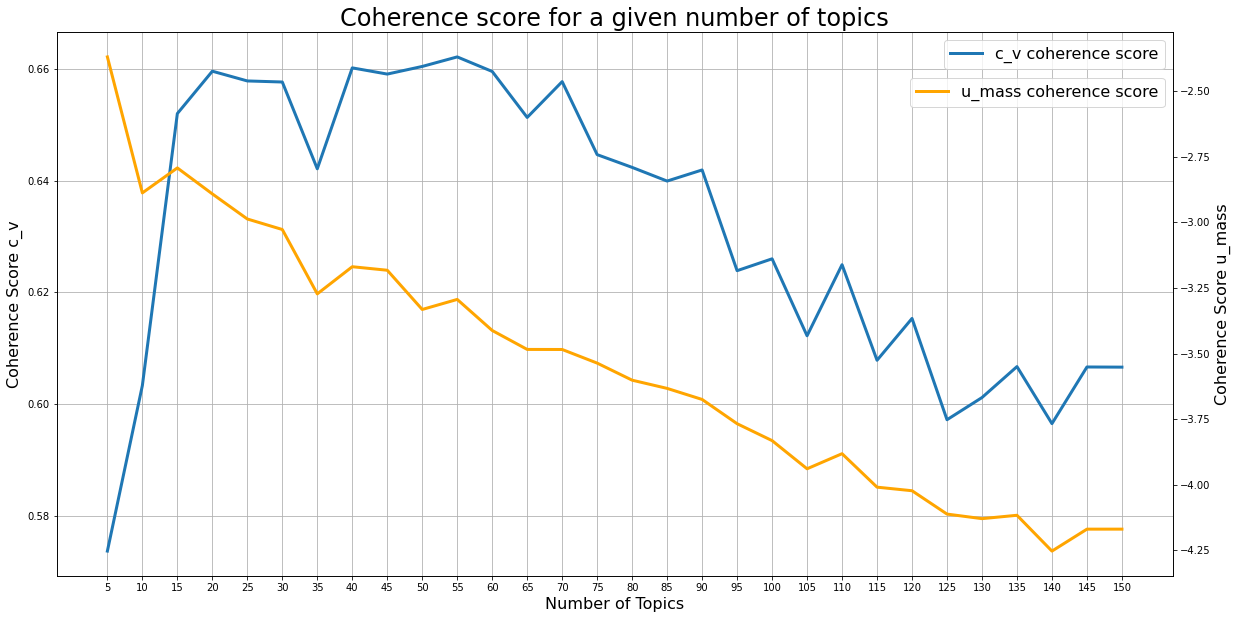

In [60]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Coherence score for a given number of topics', fontsize=24)
ax.set_xlabel('Number of Topics', fontsize=16)
ax.set_ylabel('Coherence Score c_v', fontsize=16)

ax.grid('on')

ax.plot(coherence_scores, label='c_v coherence score', linewidth=3)

ax2 = ax.twinx()
ax2.set_ylabel('Coherence Score u_mass', fontsize=16)
ax2.plot(coherence_scores_umass, label='u_mass coherence score', linewidth=3, color='orange')

ax.legend(fontsize=16)
ax2.legend(loc='upper right', bbox_to_anchor=(1, 0.93), fontsize=16)

plt.xticks(np.arange(len(n_topics_list)), n_topics_list)

In [61]:
fig.savefig('/home/olam/coherence_scores_newdata')

### 4.3 Get the coherence scores per docConcentration and topicConcentration

In [16]:
alphas = [0.1, 0.5, 0.9, 0.95, 1]
betas = [0.01, 0.05, 0.1, 0.5]

c_v_scores = {}
u_mass_scores = {}

for alpha in alphas:
    for beta in betas:

        filename = '/dlabdata1/youtube_large/olam/data/final_res/describe_topics/tune/describe_topics_ntopics55_alpha' + \
            str(alpha) + '_beta' + str(beta) + '.json'

        # Get the describe_topics dataframe
        describe_topics = spark.read.json(filename)

        # Characterize the topics with tokens
        topics = []

        for row in describe_topics.sort('topic').rdd.collect():
            tokenized_topic = []
            for j, token_id in enumerate(row.termIndices):
                tokenized_topic.append(id2word_top20[token_id])
                if j > 10:
                    break
            topics.append(tokenized_topic)

        # Compute c_v coherence score and append to coherence scores
        coherence_model = CoherenceModel(topics=topics,
                                         corpus=corpus,
                                         dictionary=FakedGensimDict(
                                             id2word_top20, S),
                                         texts=texts,
                                         coherence='c_v')

        # Compute u_mass coherence score and append to coherence scores
        coherence_model_umass = CoherenceModel(topics=topics,
                                               corpus=corpus,
                                               dictionary=FakedGensimDict(
                                                   id2word_top20, S),
                                               coherence='u_mass')

        c_v_scores[(alpha, beta)] = coherence_model.get_coherence()

        u_mass_scores[(alpha, beta)] = coherence_model_umass.get_coherence()

In [48]:
def dict2array(dict_):
    array = []
    key_prev = None
    array_sub = []
    for key, val in dict_.items():
        if key[0] != key_prev:
            key_prev = key[0]
            if array_sub != []:
                array.append(array_sub)
            array_sub = [val]
        else:
            array_sub.append(val)
    
    array.append(array_sub)
            
    return np.array(array)

In [99]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (N, M).
    row_labels
        A list or array of length N with the labels for the rows.
    col_labels
        A list or array of length M with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom", fontsize=14)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(col_labels)
    ax.set_yticklabels(row_labels)

    # Let the horizontal axes labeling appear on bottom.
    ax.tick_params(top=False, bottom=True,
                   labeltop=False, labelbottom=True)


    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.3f}",
                     textcolors=["black", "white"],
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A list or array of two color specifications.  The first is used for
        values below a threshold, the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts


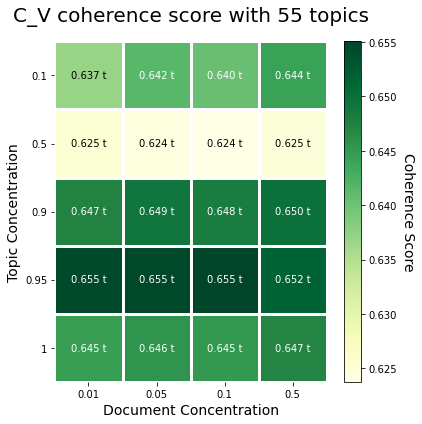

In [91]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('C_V coherence score with 55 topics', fontsize=20, pad=20)
ax.set_xlabel('Document Concentration', fontsize=14)
ax.set_ylabel('Topic Concentration', fontsize=14)

im, cbar = heatmap(dict2array(c_v_scores), alphas, betas, ax=ax,
                   cmap="YlGn", cbarlabel="Coherence Score")
texts = annotate_heatmap(im, valfmt="{x:.3f} t")

fig.tight_layout()
plt.show()


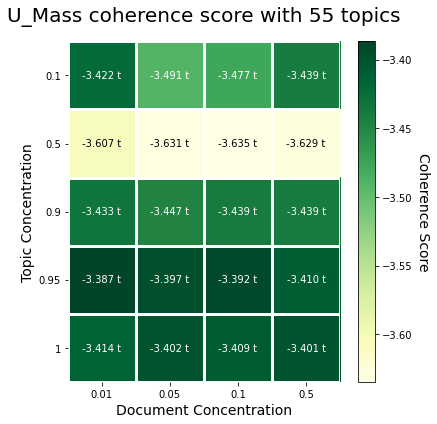

In [92]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('U_Mass coherence score with 55 topics', fontsize=20, pad=20)
ax.set_xlabel('Document Concentration', fontsize=14)
ax.set_ylabel('Topic Concentration', fontsize=14)

im, cbar = heatmap(dict2array(u_mass_scores), alphas, betas, ax=ax,
                   cmap="YlGn", cbarlabel="Coherence Score")
texts = annotate_heatmap(im, valfmt="{x:.3f} t")

fig.tight_layout()
plt.show()



## 5 Classifier

#TODO describe the utility of this section

### 5.1 Filter the data for classification

As we have filtered a specific data in the topic modelling task, we will do the same here. We do not select the data that has been used for topic modelling but we still want to use relevant data. For this, we keep only the videos with more than 10'000 views. 

We will not be able to use the already computed variable as `set_relevant_vid.pickle` or `set_relevant_vid_top20.pickle` since the index are defined for videos with more than 10'000 views from channels with more than 100'000 subs. In this case, we don't want the second condition, we just need the channel to be in the set of the crawled channels.

Finally, we will perform undersampling in order to have a balanced dataset over the categories. Plus, we will have much less data to handle, so computing the classifier for a specific clustering model will be fast. Remind that the classifier is a way to measure the topic modelling performance. 

#### 5.1.1 Get the data of the relevant videos for the classifier

In [9]:
# GET THE LIST OF RELEVANT CHANNELS

df_channelcrawler = pd.read_csv('/dlabdata1/youtube_large/channelcrawler.csv')

df_channelcrawler['channel_id'] = df_channelcrawler['link'].apply(
    lambda x: x.replace('http://www.youtube.com/channel/', ''))

# Store in a set since it will be faster to check if a channel is in channelcrawler
set_relevant_channels_classifier = set(df_channelcrawler['channel_id'])

print('There are ' + str(len(set_relevant_channels_classifier)) + ' relevant channels.')

There are 164648 relevant channels.


In [10]:
### Get the relevant features of the relevant videos

array_relevant_features = []

array_idx_relevant_vid = []

i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):

    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            # line is a byte dict, video is the corresponding dict
            video = json.loads(line)

            if check_channel(video, set_relevant_channels_classifier) and check_10000_views(video):
                
                array_idx_relevant_vid.append(i)
                
                array_vid_relevant_features = [video['channel_id']]
                array_vid_relevant_features.append(video['view_count'])
                array_vid_relevant_features.append(video['upload_date'][:4])
                array_vid_relevant_features.append(video['categories'])
        
                array_relevant_features.append(array_vid_relevant_features)

            if i % 10000000 == 0 and i != 0:
                print('Processed ' + str(i) + ' videos...')

            i += 1

Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [11]:
# Get the dataframe of all the videos that we will consider

column_names = ['channel_id', 'view_counts', 'uploaded_year', 'category']

df = pd.DataFrame(array_relevant_features, columns=column_names)

print('Shape of the DataFrame: ' + str(df.shape))

Shape of the DataFrame: (23306713, 4)


#### 5.1.2 Remove the videos that have been used for the TP model 

In [12]:
# Load set of channels with more than 100'000 subs
with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_channels.pickle', 'rb') as f:
    set_relevant_channels = pickle.load(f)
f.close()

In [13]:
df_sub100000 = df[df['channel_id'].isin(set_relevant_channels)]
df_top20 = df_sub100000.sort_values(['view_counts'], ascending=False).groupby(['category', 'uploaded_year', 'channel_id']).head(20)
index_to_remove = set(df_top20.index)
df_top20.head()

,channel_id,view_counts,uploaded_year,category
14967815,UCLp8RBhQHu9wSsq62j_Md6A,6.509934e+09,2017,Music
22890520,UC0C-w0YjGpqDXGB8IHb662A,4.468090e+09,2017,Music
11402670,UCVp3nfGRxmMadNDuVbJSk8A,4.295905e+09,2015,Music
8576308,UCcdwLMPsaU2ezNSJU1nFoBQ,3.838039e+09,2016,Education
5001984,UCmfFGTSsfJVu6CGvL8r75qg,3.709533e+09,2014,Music


In [14]:
set_relevant_vid_classifier = set()

for index in df.index:
    if index not in index_to_remove:
        set_relevant_vid_classifier.add(index)

#### 5.1.3 Get balanced data

In [23]:
df_relevant_vid_classifier = df.iloc[list(set_relevant_vid_classifier)]

In [31]:
df_relevant_vid_classifier.index[0]

52

In [26]:
df_relevant_vid_classifier['category']

52            Entertainment
53            Entertainment
54            Entertainment
55            Entertainment
56            Entertainment
                 ...       
23306708    Travel & Events
23306709    Travel & Events
23306710    Travel & Events
23306711    Travel & Events
23306712    Travel & Events
Name: category, Length: 19407399, dtype: object

In [32]:
category2idx = {}

for index, elem in zip(df_relevant_vid_classifier.index, df_relevant_vid_classifier['category']):
    if elem in category2idx.keys():
        category2idx[elem].append(index)
    else:
        category2idx[elem] = [index]

In [40]:
# Find the category with the lowest number of videos and keep this number

min_n_videos = math.inf

for key, value in category2idx.items():
    if key != '' and key != 'Shows':
        min_n_videos = min(min_n_videos, len(value))
        
category2idx_rand_undersampl = {}


# Randomly select min_n_videos indexes of each video's category 

for key, value in category2idx.items():
    category2idx_rand_undersampl[key] = random.choices(value, k=int(min_n_videos/10))
    
# Create our final array of index

index = []
for key, value in category2idx_rand_undersampl.items():
    if key != '' and key != 'Shows':
        index.extend(value)

In [44]:
with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_vid_classifier.pickle', 'wb') as f:
    pickle.dump(set(index), f)
f.close()

### 5.2 Process the data

The data input for the classifier is a vector of the distribution over the topics for each video. We will proceed with the following steps:

- Process the data so that this data can be the input of our TM model.
- Get the distribution over the topics vector for each video with the best TM model
- Get the groundtruth category of the considered videos
- Get the index for training data, validation data and testing data

**Notes**

`set_relevant_vid_classifier` is the set of index of the desired videos from the DataFrame with the relevant features

`index_dat` is the set of index of the desired videos from the file of all videos

#### 5.2.1 Get the BoW vector for each video corresponding to the vocabulary of the TM model

In [45]:
# Load dictionnary of words
with open('/dlabdata1/youtube_large/olam/data/final_res/id2word_top20.pickle', 'rb') as f:
    id2word = pickle.load(f)
f.close()

# Load index of data for classifier
with open('/dlabdata1/youtube_large/olam/data/final_res/set_relevant_vid_classifier.pickle', 'rb') as f:
    set_relevant_vid_classifier = pickle.load(f)
f.close()

In [46]:
# Get the vocabulary of the TM model
vocab = list(id2word.values())

# we need word2id in order to be able to match the token to its index in the vocabulary
word2id = {v: k for k, v in id2word.items()}


# Now we can compute the index of the videos we need for the classifier from the data of all videos
array_idx_relevant_vid.sort()

index_data = set([array_idx_relevant_vid[i] for i in set_relevant_vid_classifier])

In [48]:
# Save intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/index_data.pickle', 'wb') as f:
    pickle.dump(index_data, f)
f.close()

In [49]:
# Load intermediate result
with open('/dlabdata1/youtube_large/olam/data/final_res/index_data.pickle', 'rb') as f:
    index_data = pickle.load(f)
f.close()

In [50]:
data = dok_matrix((len(index_data), len(vocab)), dtype=np.uint8)
groundtruth = []

i_vid = 0
i = 0

for filepath in os.listdir('/dlabdata1/youtube_large/yt_metadata_en_dd/'):
    
    # Reading the file
    with gzip.open('/dlabdata1/youtube_large/yt_metadata_en_dd/' + filepath, 'rb') as f:

        for line in f:

            if i % 10000000 == 0:
                print('Processed ' + str(i) + ' videos...')

            if i in index_data:

                # line is a str dict, video is the dict corresponding to the str dict
                video = json.loads(line)

                # Get the tokens for each video and theirs number of occurences
                freq_tokens_per_video = get_freq_tokens_per_video(video)

                # For each video, create a underlying dictionnary for filling the sparse matrix efficiently
                dict_freq_tokens_for_sparse_matrix = fill_underlying_dict(
                    freq_tokens_per_video, word2id, i_vid)

                # Need to check that the video contains token from the reduced vocabulary
                if dict_freq_tokens_for_sparse_matrix != {}:

                    # Update the Sparse Matrix
                    dict.update(data, dict_freq_tokens_for_sparse_matrix)
                    i_vid += 1

                    # Get groundtruth values
                    groundtruth.append(video['categories'])
                    
            i += 1

# Save last sparse matrix
data = data.tocsr()
data = remove_zero_rows(data)
scipy.sparse.save_npz(
    '/dlabdata1/youtube_large/olam/data/final_res/matrices/data_balanced.npz', data)

Processed 0 videos...
Processed 10000000 videos...
Processed 20000000 videos...
Processed 30000000 videos...
Processed 40000000 videos...
Processed 50000000 videos...
Processed 60000000 videos...
Processed 70000000 videos...


In [53]:
# Save the corresponding groundtruths
with open('/dlabdata1/youtube_large/olam/data/final_res/groundtruth_balanced.pickle', 'wb') as f:
    pickle.dump(groundtruth, f)
f.close()

#### 5.2.2 Transform the BoW vectors to the format for applying to the PySpark TM model

In [56]:
# process for pyspark

data_spark = []

print('Process video for topic modelling...')
for i in range(data.shape[0]):

    if i % 5000000 == 0:
        print(str(i) + ' videos processed...')

    data_spark.append([i, get_dict_for_row(data.getrow(i).todok().items(), data)])

Process video for topic modelling...
0 videos processed...


In [59]:
with open('/dlabdata1/youtube_large/olam/data/final_res/classifier/data_spark_balanced.pickle', 'wb') as f:
    pickle.dump(data, f)
f.close()

In [60]:
conf = SparkConf().setMaster("local[4]").setAll(
    [('spark.executor.memory', '8g'), ('spark.driver.memory', '64g'), ('spark.driver.maxResultSize', '0')])

# create the session
spark = SparkSession.builder.appName(
    "LDA_topicmodelling").config(conf=conf).getOrCreate()

In [62]:
df = spark.createDataFrame(data_spark, ["id", "features"])

#### 5.2.3 Get the distribution over the topics for each video

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_90.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

In [ ]:
describe_topics = spark.read.json('/dlabdata1/youtube_large/olam/data/final_res/model/describe_topics/describe_topics_110.json')

# Print topics
for row in describe_topics.sort('topic').rdd.collect():
    print('Topic ' + str(row.topic) + ': ')
    term_weights = row.termWeights
    for i, token_id in enumerate(row.termIndices):
        print('   With weight of ' + str(term_weights[i]) + ' : ' + id2word[token_id] )
        if i >= 10:
            break

In [65]:
n_topics = np.arange(5, 151, 5)

In [68]:
for n_topic in n_topics:
    
    print('Get balanced data for model with ' + str(n_topic) + ' topics...')
    path_model = '/dlabdata1/youtube_large/olam/data/final_res/models/model_' + \
        str(n_topic)

    model = LocalLDAModel.load(path_model)
    transformed_data = model.transform(df)

    S = dok_matrix((len(index_data), len(vocab)))

    for i, topic_dist_one_vid in enumerate(transformed_data.select('topicDistribution').collect()):

        dict_topic_dist_one_vid = {}

        for j, prob in enumerate(topic_dist_one_vid['topicDistribution']):

            dict_topic_dist_one_vid[(i, j)] = prob

        # Fill data in to sparse matrix
        dict.update(S, dict_topic_dist_one_vid)

    path_transformed_data_balanced = '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_balanced_' + \
        str(n_topic) + '.npz'
    scipy.sparse.save_npz(path_transformed_data_balanced, S.tocsr())

Get balanced data for model with 5 topics...
Get balanced data for model with 10 topics...
Get balanced data for model with 15 topics...
Get balanced data for model with 20 topics...
Get balanced data for model with 25 topics...
Get balanced data for model with 30 topics...
Get balanced data for model with 35 topics...
Get balanced data for model with 40 topics...
Get balanced data for model with 45 topics...
Get balanced data for model with 50 topics...
Get balanced data for model with 55 topics...
Get balanced data for model with 60 topics...
Get balanced data for model with 65 topics...
Get balanced data for model with 70 topics...
Get balanced data for model with 75 topics...
Get balanced data for model with 80 topics...
Get balanced data for model with 85 topics...
Get balanced data for model with 90 topics...
Get balanced data for model with 95 topics...
Get balanced data for model with 100 topics...
Get balanced data for model with 105 topics...
Get balanced data for model with 

In [71]:
# Same for tuning the hyper parameters alpha and betas with n = 55 topics
alphas = [0.1, 0.5, 0.9, 0.95, 1]
betas = [0.01, 0.05, 0.1, 0.5]

for alpha in alphas:
    for beta in betas:

        print('Get balanced data for model with 55 topics, alpha = ' +
              str(alpha) + ', beta = ' + str(beta))
        path_model = '/dlabdata1/youtube_large/olam/data/final_res/models/tune/model_ntopics55_alpha' + \
            str(alpha) + '_beta' + str(beta)

        model = LocalLDAModel.load(path_model)
        transformed_data = model.transform(df)

        S = dok_matrix((len(index_data), len(vocab)))

        for i, topic_dist_one_vid in enumerate(transformed_data.select('topicDistribution').collect()):

            dict_topic_dist_one_vid = {}

            for j, prob in enumerate(topic_dist_one_vid['topicDistribution']):

                dict_topic_dist_one_vid[(i, j)] = prob

            # Fill data in to sparse matrix
            dict.update(S, dict_topic_dist_one_vid)

        path_transformed_data_balanced = '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_balanced_ntopic55_alpha' + \
            str(alpha) + '_beta' + str(beta) + '.npz'
        scipy.sparse.save_npz(path_transformed_data_balanced, S.tocsr())

Get balanced data for model with 55 topics, alpha = 0.1, beta = 0.01
Get balanced data for model with 55 topics, alpha = 0.1, beta = 0.05
Get balanced data for model with 55 topics, alpha = 0.1, beta = 0.1
Get balanced data for model with 55 topics, alpha = 0.1, beta = 0.5
Get balanced data for model with 55 topics, alpha = 0.5, beta = 0.01
Get balanced data for model with 55 topics, alpha = 0.5, beta = 0.05
Get balanced data for model with 55 topics, alpha = 0.5, beta = 0.1
Get balanced data for model with 55 topics, alpha = 0.5, beta = 0.5
Get balanced data for model with 55 topics, alpha = 0.9, beta = 0.01
Get balanced data for model with 55 topics, alpha = 0.9, beta = 0.05
Get balanced data for model with 55 topics, alpha = 0.9, beta = 0.1
Get balanced data for model with 55 topics, alpha = 0.9, beta = 0.5
Get balanced data for model with 55 topics, alpha = 0.95, beta = 0.01
Get balanced data for model with 55 topics, alpha = 0.95, beta = 0.05
Get balanced data for model with 55 to

#### 5.2.4 Random under sampling and split the data into training, validation and testing data

In [2]:
# Load groundtruth
with open('/dlabdata1/youtube_large/olam/data/final_res/groundtruth.pickle', 'rb') as f:
    groundtruth = pickle.load(f)
f.close()

In [73]:
number_videos_in_dataset = len(groundtruth)

In [74]:
index = np.arange(number_videos_in_dataset)
np.random.shuffle(index)

In [75]:
# Save list of shuffled index for reproducibility
with open('/dlabdata1/youtube_large/olam/data/final_res/list_suffled_balanced_idx.pickle', 'wb') as f:
    pickle.dump(index, f)
f.close()

In [41]:
# Load list of shuffled index for balanced data
with open('/dlabdata1/youtube_large/olam/data/final_res/list_suffled_balanced_idx.pickle', 'rb') as f:
    index = pickle.load(f)
f.close()

In [76]:
training_val_model_threshold = int(0.8 * number_videos_in_dataset)
training_model_threshold = int(0.65 * number_videos_in_dataset)

list_train_idx = np.sort(index[:training_model_threshold])
list_val_idx = np.sort(index[training_model_threshold:training_val_model_threshold])
list_test_idx = np.sort(index[training_val_model_threshold:])

print(len(list_train_idx) + len(list_val_idx) + len(list_test_idx) == number_videos_in_dataset)

True


### 5.3 SVM Classifier

#### 5.3.1 Hyperparameter Tuning

In [48]:
# Initialize the hyperparameter
alphas = np.logspace(0, 1, num=20, base=100) / 100

accuracies = []

for i, alpha in enumerate(alphas):

    start = time.time()
    clf = SGDClassifier(loss='hinge', alpha=alpha, max_iter=50, shuffle=True, n_jobs=10, random_state=1)
    clf.fit(data[list_train_idx],
            y=np.array(groundtruth)[list_train_idx])
    
    y_pred = clf.predict(data[list_val_idx])
    y_gt = np.array(groundtruth)[list_val_idx]
    
    score = accuracy_score(y_gt, y_pred)
    accuracies.append(score)
    print('time for iter ' + str(i) + ': ' + str((time.time() - start) / 60))
    print('score: ' + str(score))
    print('')

time for iter 0: 0.2947763284047445
score: 0.5052102063351709

time for iter 1: 0.25506953001022337
score: 0.5043428963077977

time for iter 2: 0.2771483262379964
score: 0.5042075113279151

time for iter 3: 0.30004205703735354
score: 0.5042709730372351

time for iter 4: 0.3001961390177409
score: 0.5037421254595685

time for iter 5: 0.3089449206988017
score: 0.5036575098471419

time for iter 6: 0.30485442876815794
score: 0.5020371208691715

time for iter 7: 0.29340293804804485
score: 0.50034903940126

time for iter 8: 0.3091677824656169
score: 0.4952678718750397

time for iter 9: 0.3259780923525492
score: 0.48506745979700716

time for iter 10: 0.39190824031829835
score: 0.49180709332678973

time for iter 11: 1.0898269931475322
score: 0.4998413457267

time for iter 12: 1.7938348730405171
score: 0.33970206842864575

time for iter 13: 1.5399272004763285
score: 0.3005673476813207

time for iter 14: 1.336052906513214
score: 0.2583526186416656

time for iter 15: 1.0632218996683755
score: 0.22

In [49]:
best_alpha = alphas[np.argmax(accuracies)]
print('The optimal alpha is : alpha = ' + str(best_alpha))

The optimal alpha is : alpha = 0.01


#### 5.3.2 Get results on testing data

In [50]:
clf = SGDClassifier(loss='hinge', alpha=best_alpha, max_iter=50, shuffle=True, n_jobs=10, random_state=1)
clf.fit(data[list_train_idx],
        y=np.array(groundtruth)[list_train_idx])

SGDClassifier(alpha=0.01, max_iter=50, n_jobs=10, random_state=1)

In [51]:
Y_pred_train = clf.predict(data[list_train_idx])
y_gt_train = np.array(groundtruth)[list_train_idx]

score_train = accuracy_score(y_gt_train, Y_pred_train)

print('Accuracy on training set of the best model: ' + str(score_train))

Accuracy on training set of the best model: 0.5040015152742968


In [52]:
y_pred = clf.predict(data[list_test_idx])
y_gt = np.array(groundtruth)[list_test_idx]

score_test = accuracy_score(y_gt, y_pred)

print('Accuracy on test set of the best model: ' + str(score_test))

Accuracy on test set of the best model: 0.5040488656195462


In [13]:
with open('/dlabdata1/youtube_large/olam/data/final_res/results/y_pred.pickle', 'wb') as f:
    pickle.dump(y_pred, f)
f.close()

with open('/dlabdata1/youtube_large/olam/data/final_res/results/y_gt.pickle', 'wb') as f:
    pickle.dump(y_gt, f)
f.close()

In [53]:
# Print the precision and recall, among other metrics
print(classification_report(y_gt, y_pred, digits=3))

                       precision    recall  f1-score   support

     Autos & Vehicles      0.556     0.826     0.665     21034
               Comedy      0.486     0.403     0.440     20952
            Education      0.464     0.345     0.396     21162
        Entertainment      0.260     0.125     0.169     21118
     Film & Animation      0.352     0.145     0.205     21137
               Gaming      0.567     0.745     0.644     21098
        Howto & Style      0.514     0.577     0.544     21064
                Music      0.532     0.715     0.610     21074
      News & Politics      0.510     0.773     0.615     20720
Nonprofits & Activism      0.459     0.398     0.427     20717
       People & Blogs      0.153     0.037     0.060     21108
       Pets & Animals      0.554     0.777     0.647     20885
 Science & Technology      0.513     0.582     0.545     21047
               Sports      0.526     0.640     0.577     21097
      Travel & Events      0.534     0.480     0.505  

#### 5.3.3 Accuracy score for clustering model with given k number of topics

In [110]:
n_topics = np.arange(5, 151, 5)
# Initialize the hyperparameter
alphas_svm = np.logspace(0, 1, num=20, base=100) / 100

accuracies = []

for n_topic in n_topics:

    print('Tuning svm hyperparameter for model with ' +
          str(n_topic) + ' topics...')

    accuracies_tmp = []

    data = scipy.sparse.load_npz(
        '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_balanced_' + str(n_topic) + '.npz')

    for alpha_svm in alphas_svm:

        clf = SGDClassifier(loss='hinge', alpha=alpha_svm,
                            max_iter=100, shuffle=True, n_jobs=10, random_state=1)
        clf.fit(data[list_train_idx],
                y=np.array(groundtruth)[list_train_idx])

        y_pred = clf.predict(data[list_val_idx])
        y_gt = np.array(groundtruth)[list_val_idx]

        score = accuracy_score(y_gt, y_pred)
        accuracies_tmp.append(score)

    best_alpha_svm = alphas_svm[np.argmax(accuracies_tmp)]

    clf = SGDClassifier(loss='hinge', alpha=best_alpha_svm,
                        max_iter=100, shuffle=True, n_jobs=10, random_state=1)
    clf.fit(data[np.concatenate([list_train_idx,list_val_idx])],
            y=np.array(groundtruth)[np.concatenate([list_train_idx,list_val_idx])])
    
    y_pred = clf.predict(data[list_test_idx])
    y_gt = np.array(groundtruth)[list_test_idx]

    score_test = accuracy_score(y_gt, y_pred)
    print('Accuracy score : ' + str(score_test))
    
    accuracies.append(score_test)

Tuning svm hyperparameter for model with 5 topics...
Accuracy score : 0.21978936585678158
Tuning svm hyperparameter for model with 10 topics...
Accuracy score : 0.34024776721405936
Tuning svm hyperparameter for model with 15 topics...
Accuracy score : 0.400653029866513
Tuning svm hyperparameter for model with 20 topics...
Accuracy score : 0.42194052306411856
Tuning svm hyperparameter for model with 25 topics...
Accuracy score : 0.43666570632862767
Tuning svm hyperparameter for model with 30 topics...
Accuracy score : 0.4605141009635392
Tuning svm hyperparameter for model with 35 topics...
Accuracy score : 0.4764557124107686
Tuning svm hyperparameter for model with 40 topics...
Accuracy score : 0.4591056051730209
Tuning svm hyperparameter for model with 45 topics...
Accuracy score : 0.4415954415954416
Tuning svm hyperparameter for model with 50 topics...
Accuracy score : 0.4662121066615449
Tuning svm hyperparameter for model with 55 topics...
Accuracy score : 0.46992541374563845
Tuning 

([<matplotlib.axis.XTick at 0x7fd44a176df0>,
 [Text(0, 0, '5'),
  Text(1, 0, '10'),
  Text(2, 0, '15'),
  Text(3, 0, '20'),
  Text(4, 0, '25'),
  Text(5, 0, '30'),
  Text(6, 0, '35'),
  Text(7, 0, '40'),
  Text(8, 0, '45'),
  Text(9, 0, '50'),
  Text(10, 0, '55'),
  Text(11, 0, '60'),
  Text(12, 0, '65'),
  Text(13, 0, '70'),
  Text(14, 0, '75'),
  Text(15, 0, '80'),
  Text(16, 0, '85'),
  Text(17, 0, '90'),
  Text(18, 0, '95'),
  Text(19, 0, '100'),
  Text(20, 0, '105'),
  Text(21, 0, '110'),
  Text(22, 0, '115'),
  Text(23, 0, '120'),
  Text(24, 0, '125'),
  Text(25, 0, '130'),
  Text(26, 0, '135'),
  Text(27, 0, '140'),
  Text(28, 0, '145'),
  Text(29, 0, '150')])

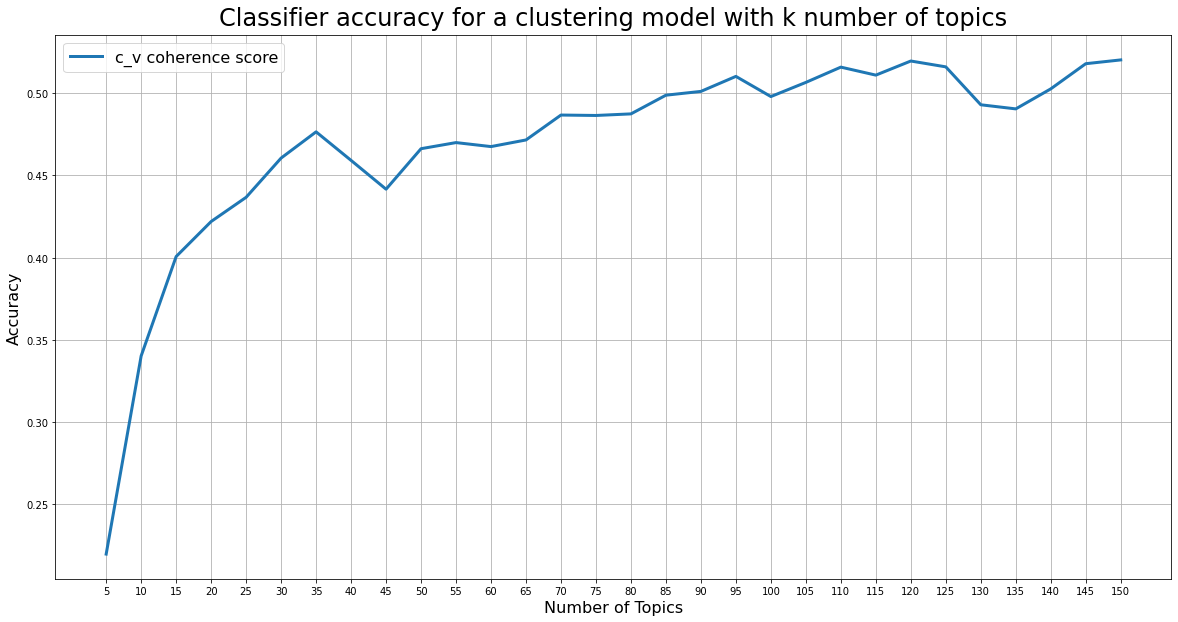

In [111]:
fig, ax = plt.subplots(figsize=(20, 10))

ax.set_title('Classifier accuracy for a clustering model with k number of topics', fontsize=24, pad=10)
ax.set_xlabel('Number of Topics', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)

ax.grid('on')

ax.plot(accuracies, label='c_v coherence score', linewidth=3)

ax.legend(fontsize=16)

plt.xticks(np.arange(len(n_topics)), n_topics)

In [112]:
print('Number of topic that give the best accuracy: ' + str(n_topics[np.argmax(accuracies)]))

Number of topic that give the best accuracy: 150


In [113]:
print('Accuracy score for 55 topics: ' + str(accuracies[list(n_topics).index(55)]))

Accuracy score for 55 topics: 0.46992541374563845


#### 5.3.4 Accuracy score for clustering models with 55 topics and tuned docConcetration/topicConcentration 

In [ ]:
n_topic = 55
alphas = [0.1, 0.5, 0.9, 0.95, 1]
betas = [0.01, 0.05, 0.1, 0.5]

# Initialize the hyperparameter
alphas_svm = np.logspace(0, 1, num=20, base=100) / 100

accuracies = []

for alpha in alphas:
    
    accuracies_alpha = []
    
    for beta in betas:

        print('Tuning svm hyperparameter for model with 55 topics, alpha = ' +
              str(alpha) + ', beta = ' + str(beta))

        accuracies_tmp = []

        data = scipy.sparse.load_npz(
            '/dlabdata1/youtube_large/olam/data/final_res/matrices/transformed_data_balanced_ntopic55_alpha' + str(alpha) + '_beta' + str(beta) + '.npz')

        for alpha_svm in alphas_svm:

            clf = SGDClassifier(loss='hinge', alpha=alpha_svm,
                                max_iter=100, shuffle=True, n_jobs=10, random_state=1)
            clf.fit(data[list_train_idx],
                    y=np.array(groundtruth)[list_train_idx])

            y_pred = clf.predict(data[list_val_idx])
            y_gt = np.array(groundtruth)[list_val_idx]

            score = accuracy_score(y_gt, y_pred)
            accuracies_tmp.append(score)

        best_alpha_svm = alphas_svm[np.argmax(accuracies_tmp)]

        clf = SGDClassifier(loss='hinge', alpha=best_alpha_svm,
                            max_iter=100, shuffle=True, n_jobs=10, random_state=1)
        clf.fit(data[np.concatenate([list_train_idx, list_val_idx])],
                y=np.array(groundtruth)[np.concatenate([list_train_idx, list_val_idx])])

        y_pred = clf.predict(data[list_test_idx])
        y_gt = np.array(groundtruth)[list_test_idx]

        score_test = accuracy_score(y_gt, y_pred)
        print('Accuracy score : ' + str(score_test))

        accuracies_alpha.append(score_test)
    
    accuracies.append(accuracies_alpha)

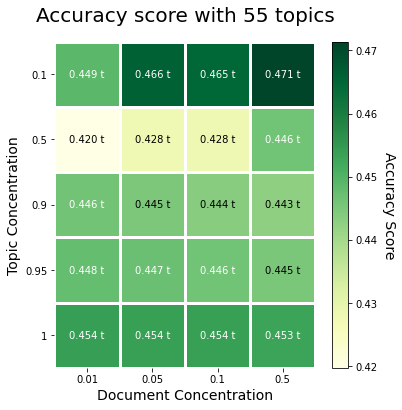

In [103]:
fig, ax = plt.subplots(figsize=(6, 6))

ax.set_title('Accuracy score with 55 topics', fontsize=20, pad=20)
ax.set_xlabel('Document Concentration', fontsize=14)
ax.set_ylabel('Topic Concentration', fontsize=14)

im, cbar = heatmap(np.array(accuracies), alphas, betas, ax=ax,
                   cmap="YlGn", cbarlabel="Accuracy Score")
texts = annotate_heatmap(im, valfmt="{x:.3f} t")

#fig.tight_layout()
plt.show()


### 5.4 MLP Classifier

In [6]:
clf = MLPClassifier(random_state=1, max_iter=10, early_stopping=True, validation_fraction=0.15, verbose=True)

In [7]:
list_train_idx = np.append(list_train_idx, list_val_idx)

In [8]:
clf.fit(data[list_train_idx], np.array(groundtruth)[list_train_idx])

Iteration 1, loss = 1.16384494
Validation score: 0.640175
Iteration 2, loss = 1.12465831
Validation score: 0.644169
Iteration 3, loss = 1.11630461
Validation score: 0.645119
Iteration 4, loss = 1.11303818
Validation score: 0.646347
Iteration 5, loss = 1.11113296
Validation score: 0.645829
Iteration 6, loss = 1.10989572
Validation score: 0.646874
Iteration 7, loss = 1.10904122
Validation score: 0.647241
Iteration 8, loss = 1.10837611
Validation score: 0.646867
Iteration 9, loss = 1.10784688
Validation score: 0.647589
Iteration 10, loss = 1.10745249
Validation score: 0.647866


/home/olam/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(early_stopping=True, max_iter=10, random_state=1,
              validation_fraction=0.15, verbose=True)

In [9]:
y_pred = clf.predict(data[list_test_idx])
y_gt = np.array(groundtruth)[list_test_idx]

score_test = accuracy_score(y_gt, y_pred)

print('Accuracy on testing data of the best model: ' + str(score_test))

Accuracy on test set of the best model: 0.6483169739862892


In [10]:
# Print the precision and recall, among other metrics
print(classification_report(y_gt, y_pred, digits=3))

/home/olam/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


                       precision    recall  f1-score   support

                           0.000     0.000     0.000        55
     Autos & Vehicles      0.693     0.771     0.730    121091
               Comedy      0.447     0.195     0.272     75185
            Education      0.517     0.412     0.459    163608
        Entertainment      0.562     0.615     0.588    798876
     Film & Animation      0.486     0.198     0.282    148580
               Gaming      0.824     0.900     0.860    891742
        Howto & Style      0.606     0.604     0.605    235698
                Music      0.659     0.795     0.721    441745
      News & Politics      0.707     0.743     0.725    227835
Nonprofits & Activism      0.410     0.176     0.246     20805
       People & Blogs      0.382     0.232     0.289    323900
       Pets & Animals      0.504     0.558     0.530     26306
 Science & Technology      0.567     0.565     0.566    129460
                Shows      0.000     0.000     0.000  

In [12]:
dump(clf, '/dlabdata1/youtube_large/olam/data/final_res/classifier/mlp_10iter.joblib')

['/dlabdata1/youtube_large/olam/data/final_res/classifier/mlp_10iter.joblib']

In [13]:
clf_load = load('/dlabdata1/youtube_large/olam/data/final_res/classifier/mlp_10iter.joblib')

In [15]:
y_pred_test = clf_load.predict(data[list_test_idx])
y_gt_test = np.array(groundtruth)[list_test_idx]

score_test_test = accuracy_score(y_gt_test, y_pred_test)

print('Accuracy on test set of the best model: ' + str(score_test_test))

Accuracy on test set of the best model: 0.6483169739862892
